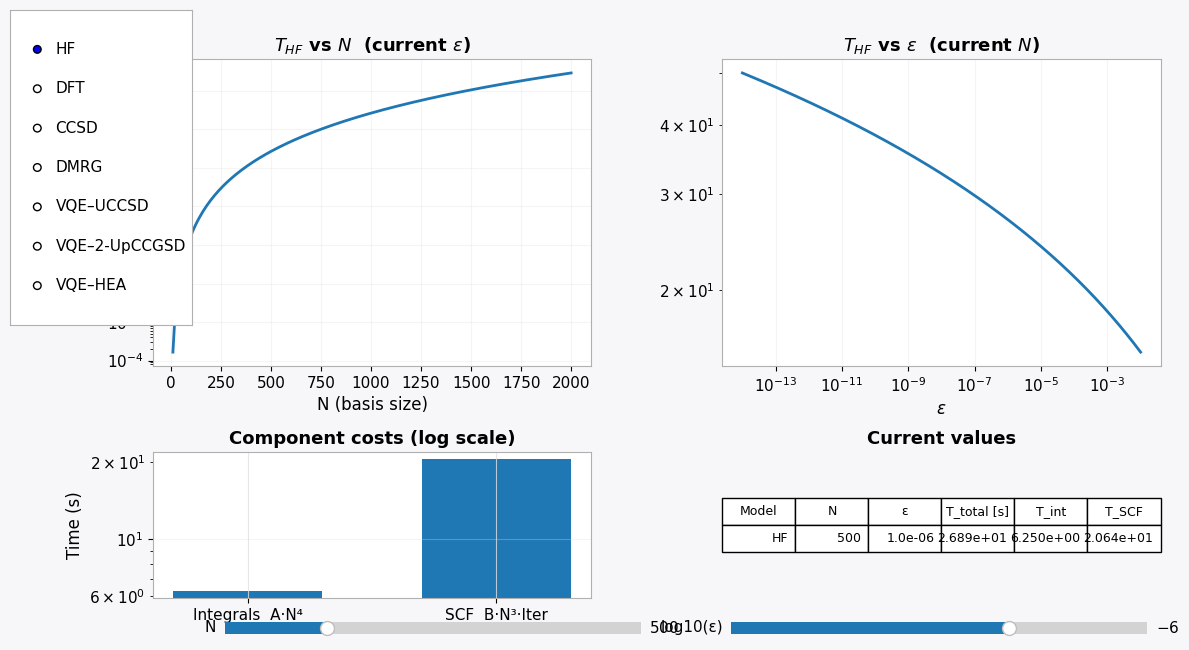

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons

# ---------- Common helpers ----------
def logiter(alpha, E0, eps, beta):
    return np.maximum(0.0, alpha * np.log(E0 / eps)) + beta

# ---------- Model implementations ----------
class HF:
    name = "HF"
    A, B, alpha, beta, E0 = 1e-10, 1e-8, 1.0, 5.0, 1e-1
    def T(self, N, eps):
        it = logiter(self.alpha, self.E0, eps, self.beta)
        return self.A*N**4 + self.B*N**3*it
    def components(self, N, eps):
        it = logiter(self.alpha, self.E0, eps, self.beta)
        return ["Integrals  A·N⁴", "SCF  B·N³·Iter"], [self.A*N**4, self.B*N**3*it]
    def vlines(self, N):  # no special markers
        return []

class DFT:
    name = "DFT"
    A, B, alpha, beta, E0 = 1e-9, 2e-9, 1.0, 5.0, 1e-1
    def T(self, N, eps):
        it = logiter(self.alpha, self.E0, eps, self.beta)
        return N**3 * (self.A + self.B*it)
    def components(self, N, eps):
        it = logiter(self.alpha, self.E0, eps, self.beta)
        return ["Build  A·N³", "SCF  B·N³·Iter"], [self.A*N**3, self.B*N**3*it]
    def vlines(self, N): return []

class CCSD:
    name = "CCSD"
    A, B, alpha, beta, E0 = 1e-13, 4e-14, 1.0, 10.0, 1e-1
    def T(self, N, eps):
        it = logiter(self.alpha, self.E0, eps, self.beta)
        return N**6 * (self.A + self.B*it)
    def components(self, N, eps):
        it = logiter(self.alpha, self.E0, eps, self.beta)
        return ["Setup  A·N⁶", "Iter.  B·N⁶·Iter"], [self.A*N**6, self.B*N**6*it]
    def vlines(self, N): return []

class DMRG:
    name = "DMRG"
    A_prep, B_sweep, gamma, delta, S, E0 = 1e-10, 8e-9, 1.0, 20.0, 10.0, 1e-1
    def M(self, eps):
        return np.maximum(0.0, self.gamma*np.log(self.E0/eps)) + self.delta
    def T(self, N, eps):
        return self.A_prep*N**4 + self.B_sweep*self.S*N*self.M(eps)**3
    def components(self, N, eps):
        return ["Prep  A_prep·N⁴", "Sweeps  B_sweep·S·N·M³"], \
               [self.A_prep*N**4, self.B_sweep*self.S*N*self.M(eps)**3]
    def vlines(self, N): return []

class VQE_UCCSD:
    name = "VQE–UCCSD"
    alpha, beta, sigma2 = 1.0, 20.0, 1.0
    c1, tau_gate, p_gate, T2, E0 = 1e-2, 1e-6, 1e-3, 0.1, 1e-1
    def D(self, N): return self.c1*N**4
    def eps_noise(self, N): return self.D(N)*(self.p_gate + self.tau_gate/self.T2)
    def opt_calls(self, eps): return logiter(self.alpha, self.E0, eps, self.beta)
    def shots(self, N, eps):
        denom = np.maximum(1e-30, np.abs(eps - self.eps_noise(N)))
        return self.sigma2/(denom**2)
    def per_eval(self, N): return self.D(N)*self.tau_gate
    def T(self, N, eps): return self.opt_calls(eps)*self.shots(N, eps)*self.per_eval(N)
    def components(self, N, eps):
        return ["per-eval  c₁·N⁴·τ_gate", "TOTAL"], [self.per_eval(N), self.T(N, eps)]
    def vlines(self, N):
        return [(self.eps_noise(N), ":", r"$\varepsilon_{\rm noise}(N)$")]

class VQE_2UpCCGSD:
    name = "VQE–2-UpCCGSD"
    alpha, beta, sigma2 = 1.0, 20.0, 1.0
    c2, k, kappa = 1e-2, 2.0, 1.0
    tau_gate, p_gate, T2, E0 = 1e-6, 1e-3, 0.1, 1e-1
    def depth(self, N): return self.c2*self.k*N**2
    def bias(self): return np.exp(-self.kappa*self.k)
    def eps_noise(self, N): return self.depth(N)*(self.p_gate + self.tau_gate/self.T2)
    def opt_calls(self, eps): return logiter(self.alpha, self.E0, eps, self.beta)
    def shots(self, N, eps):
        denom = np.maximum(1e-30, np.abs(eps - self.bias() - self.eps_noise(N)))
        return self.sigma2/(denom**2)
    def per_eval(self, N): return self.depth(N)*self.tau_gate
    def T(self, N, eps): return self.opt_calls(eps)*self.shots(N, eps)*self.per_eval(N)
    def components(self, N, eps):
        return ["per-eval  c₂·k·N²·τ_gate", "TOTAL"], [self.per_eval(N), self.T(N, eps)]
    def vlines(self, N):
        return [(self.bias(), "--", r"bias $e^{-\kappa k}$"),
                (self.bias()+self.eps_noise(N), ":", r"$b_k+\varepsilon_{\rm noise}(N)$")]

class VQE_HEA:
    name = "VQE–HEA"
    alpha, beta, sigma2 = 1.0, 20.0, 1.0
    d_layers, mu = 5.0, 0.5
    tau_gate, p_gate, T2, E0 = 1e-6, 1e-3, 0.1, 1e-1
    def depth(self, N): return self.d_layers*N
    def bias(self): return np.exp(-self.mu*self.d_layers)
    def eps_noise(self, N): return self.depth(N)*(self.p_gate + self.tau_gate/self.T2)
    def opt_calls(self, eps): return logiter(self.alpha, self.E0, eps, self.beta)
    def shots(self, N, eps):
        denom = np.maximum(1e-30, np.abs(eps - self.bias() - self.eps_noise(N)))
        return self.sigma2/(denom**2)
    def per_eval(self, N): return self.depth(N)*self.tau_gate
    def T(self, N, eps): return self.opt_calls(eps)*self.shots(N, eps)*self.per_eval(N)
    def components(self, N, eps):
        return ["per-eval  d·N·τ_gate", "TOTAL"], [self.per_eval(N), self.T(N, eps)]
    def vlines(self, N):
        return [(self.bias(), "--", r"bias $e^{-\mu d}$"),
                (self.bias()+self.eps_noise(N), ":", r"$b_d+\varepsilon_{\rm noise}(N)$")]

MODELS = [HF(), DFT(), CCSD(), DMRG(), VQE_UCCSD(), VQE_2UpCCGSD(), VQE_HEA()]
name_to_model = {m.name: m for m in MODELS}

# ---------- Figure ----------
plt.close("all")
fig = plt.figure(figsize=(13, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[4, 1.9], wspace=0.30, hspace=0.38)

axN   = fig.add_subplot(gs[0, 0])
axE   = fig.add_subplot(gs[0, 1])
axBar = fig.add_subplot(gs[1, 0])
axTbl = fig.add_subplot(gs[1, 1])

# radio buttons
rax = fig.add_axes([0.015, 0.50, 0.14, 0.45])
radio = RadioButtons(rax, [m.name for m in MODELS], active=0)

# sliders
axN_slider   = fig.add_axes([0.18, 0.05, 0.32, 0.035])
axEps_slider = fig.add_axes([0.57, 0.05, 0.32, 0.035])

# shared domains
Nmin, Nmax = 10, 2000
logeps_min, logeps_max = -14, -2
Ns = np.arange(Nmin, Nmax + 1, 10)
eps_grid = 10**np.linspace(logeps_min, logeps_max, 600)

# initial values
N0 = 500
eps0 = 1e-6
sN = Slider(axN_slider, "N", Nmin, Nmax, valinit=N0, valstep=10)
sLogEps = Slider(axEps_slider, r"log10(ε)", logeps_min, logeps_max, valinit=np.log10(eps0))

# state for vertical lines
vlines = []

def refresh(model, Nval, epsval):
    # -- Top left: T vs N --
    axN.clear()
    axN.plot(Ns, model.T(Ns, epsval), lw=2)
    axN.set_title(f"$T_{{{model.name}}}$ vs $N$  (current $\\varepsilon$)")
    axN.set_xlabel("N (basis size)"); axN.set_ylabel("Time (s)")
    axN.set_yscale("log"); axN.grid(True, alpha=0.3)

    # -- Top right: T vs eps --
    axE.clear()
    axE.plot(eps_grid, model.T(Nval, eps_grid), lw=2)
    axE.set_xscale("log"); axE.set_yscale("log")
    axE.set_xlabel(r"$\varepsilon$")
    axE.set_title(f"$T_{{{model.name}}}$ vs $\\varepsilon$  (current $N$)")
    axE.grid(True, alpha=0.3)

    # markers (noise/bias) if provided
    for x, style, label in model.vlines(Nval):
        axE.axvline(x, ls=style, label=label)
    if model.vlines(Nval):
        axE.legend(frameon=False, fontsize=9)

    # -- Bottom-left: components --
    axBar.clear()
    labels, vals = model.components(Nval, epsval)
    axBar.bar(range(len(vals)), vals, width=0.6)
    axBar.set_xticks(range(len(vals)), labels)
    axBar.set_ylabel("Time (s)")
    axBar.set_yscale("log"); axBar.grid(True, axis="y", alpha=0.3)
    axBar.set_title("Component costs (log scale)")

    # -- Bottom-right: table --
    axTbl.clear(); axTbl.axis("off")
    # common readouts
    cols = ["Model", "N", "ε", "T_total [s]"]
    row  = [model.name, f"{int(Nval)}", f"{epsval:.1e}", f"{np.squeeze(model.T(Nval, epsval)):.3e}"]

    # enrich with model-specific info
    if isinstance(model, HF):
        cols += ["T_int", "T_SCF"]
        row  += [f"{model.A*Nval**4:.3e}", f"{model.B*Nval**3*logiter(model.alpha, model.E0, epsval, model.beta):.3e}"]
    elif isinstance(model, DFT):
        cols += ["T_build", "T_SCF"]
        row  += [f"{model.A*Nval**3:.3e}", f"{model.B*Nval**3*logiter(model.alpha, model.E0, epsval, model.beta):.3e}"]
    elif isinstance(model, CCSD):
        cols += ["T_setup", "T_iter"]
        row  += [f"{model.A*Nval**6:.3e}", f"{model.B*Nval**6*logiter(model.alpha, model.E0, epsval, model.beta):.3e}"]
    elif isinstance(model, DMRG):
        cols += ["M(ε)", "T_prep", "T_sweeps"]
        Mv = model.M(epsval)
        row += [f"{np.squeeze(Mv):.3f}",
                f"{model.A_prep*Nval**4:.3e}",
                f"{model.B_sweep*model.S*Nval*Mv**3:.3e}"]
    elif isinstance(model, VQE_UCCSD):
        cols += ["ε_noise(N)", "per-eval"]
        row  += [f"{model.eps_noise(Nval):.1e}", f"{model.per_eval(Nval):.3e}"]
    elif isinstance(model, VQE_2UpCCGSD):
        cols += ["bias", "ε_noise(N)", "ε_floor", "per-eval"]
        b = model.bias()
        en = model.eps_noise(Nval)
        row += [f"{b:.1e}", f"{en:.1e}", f"{(b+en):.1e}", f"{model.per_eval(Nval):.3e}"]
    elif isinstance(model, VQE_HEA):
        cols += ["bias", "ε_noise(N)", "ε_floor", "per-eval"]
        b = model.bias()
        en = model.eps_noise(Nval)
        row += [f"{b:.1e}", f"{en:.1e}", f"{(b+en):.1e}", f"{model.per_eval(Nval):.3e}"]

    table = axTbl.table(cellText=[row], colLabels=cols, loc="center")
    table.auto_set_font_size(False); table.set_fontsize(9); table.scale(1.0, 1.6)
    axTbl.set_title("Current values")

    fig.canvas.draw_idle()

# initial draw
current = MODELS[0]
refresh(current, N0, eps0)

def on_change(_):
    model = current  # will be updated by radio callback
    Nval = int(sN.val)
    epsval = 10**(sLogEps.val)
    refresh(model, Nval, epsval)

def on_radio(label):
    global current
    current = name_to_model[label]
    on_change(None)

sN.on_changed(on_change)
sLogEps.on_changed(on_change)
radio.on_clicked(on_radio)

plt.show()
